In [112]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score
from sklearn.model_selection import cross_val_score

In [66]:
# Dataset from https://www.kaggle.com/jessemostipak/hotel-booking-demand

df = pd.read_csv('./Data/hotel_bookings.csv')

In [67]:
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [68]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [69]:
df.children = df.children.fillna(0)
df.country = df.country.fillna(0)

In [70]:
# Dropping redundand and unneccessary information

df = df.drop(['arrival_date_year', 'arrival_date_week_number', 'company', 'reservation_status', 'reservation_status_date'], axis = 1)

In [71]:
# Defining categories so these values are not mistaken as numeric information 

new_categories = ['hotel', 'arrival_date_month', 'arrival_date_day_of_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'customer_type']

for col in new_categories:
    df[col] = df[col].astype('category')

In [72]:
df.dtypes

hotel                             category
is_canceled                          int64
lead_time                            int64
arrival_date_month                category
arrival_date_day_of_month         category
stays_in_weekend_nights              int64
stays_in_week_nights                 int64
adults                               int64
children                           float64
babies                               int64
meal                              category
country                           category
market_segment                    category
distribution_channel              category
is_repeated_guest                 category
previous_cancellations               int64
previous_bookings_not_canceled       int64
reserved_room_type                category
assigned_room_type                category
booking_changes                      int64
deposit_type                      category
agent                             category
days_in_waiting_list                 int64
customer_ty

In [73]:
df = pd.get_dummies(df)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Columns: 619 entries, is_canceled to customer_type_Transient-Party
dtypes: float64(2), int64(12), uint8(605)
memory usage: 81.6 MB


In [75]:
# Creating df_compact with only relevant columns for prediction of cancellation

In [76]:
# As seen in "Hotel_Cancellation_Feature_Correlations.ipynb" only "country_PRT" plays a role in cancellation rate and thus is kept here.

selected_cols = ('market_segment', 'distribution_channel', 'deposit_type', 'hotel')
filter_cols = [col for col in df if col.startswith(selected_cols)]
df_compact = df[['is_canceled', 'lead_time', 'previous_cancellations', 'required_car_parking_spaces', 'total_of_special_requests', 'country_PRT']]
df2 = df[filter_cols]
df_compact = pd.concat([df_compact, df2], axis = 1)

In [77]:
# fig, ax = plt.subplots(figsize=(20, 15)) 
# sns.heatmap(df_compact.corr(), annot=True, ax = ax)

In [78]:
# Cancellation Rate

In [79]:
# Cancellation prediction - all data (df) but without reservation_status

In [80]:
X = df.drop(['is_canceled'], axis = 1)
y = df['is_canceled']
y = np.array(y)

In [81]:
# Scaling

X_scaled = StandardScaler().fit_transform(X)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 4)

In [85]:
# Logistic Regression
model_lr = LogisticRegression().fit(X_train, y_train)
model_lr_prediction = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, model_lr_prediction)
accuracy_lr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8345757601139124

In [86]:
kappa_lr = cohen_kappa_score(y_test, model_lr_prediction)
kappa_lr

0.6366425648324665

Feature: 0, Score: 0.67611
Feature: 1, Score: 0.10591
Feature: 2, Score: 0.15117
Feature: 3, Score: 0.10198
Feature: 4, Score: 0.08845
Feature: 5, Score: 0.00047
Feature: 6, Score: 1.70051
Feature: 7, Score: -0.51270
Feature: 8, Score: -0.23889
Feature: 9, Score: -0.04138
Feature: 10, Score: 0.18968
Feature: 11, Score: -5.00971
Feature: 12, Score: -0.65907
Feature: 13, Score: 0.07629
Feature: 14, Score: -0.07629
Feature: 15, Score: 0.04848
Feature: 16, Score: -0.05279
Feature: 17, Score: 0.02961
Feature: 18, Score: 0.02924
Feature: 19, Score: -0.00033
Feature: 20, Score: -0.09905
Feature: 21, Score: -0.02485
Feature: 22, Score: 0.00783
Feature: 23, Score: 0.04448
Feature: 24, Score: 0.02601
Feature: 25, Score: 0.03848
Feature: 26, Score: -0.02206
Feature: 27, Score: -0.02546
Feature: 28, Score: -0.00561
Feature: 29, Score: -0.00655
Feature: 30, Score: -0.02480
Feature: 31, Score: 0.02248
Feature: 32, Score: -0.01991
Feature: 33, Score: -0.00326
Feature: 34, Score: 0.02044
Feature: 35, 

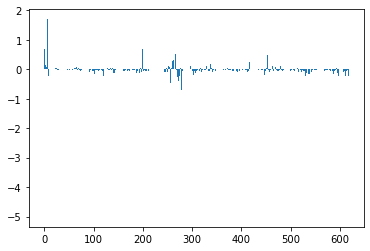

In [87]:

#Feature importance

feature_lr = []

# Get importance
importance = model_lr.coef_[0]

# Summarize feature importance
for i,v in enumerate(importance):
	feature_lr.append(v)
	print('Feature: %0d, Score: %.5f' % (i,v))
 
# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [88]:
# Sorting the features by importance

# Turning negative into positive scores
for i in range(len(feature_lr)):
    if feature_lr[i]<0:
        feature_lr[i] = feature_lr[i]*(-1)

feature_lr = pd.DataFrame(feature_lr)
feature_lr.reset_index(inplace=True)
feature_lr.columns = ['feature', 'score']
feature_lr['feature_name'] = X.columns
feature_lr.sort_values(by=['score'], ascending = False, inplace=True)
feature_lr.reset_index(drop = True, inplace = True)
feature_lr

,feature,score,feature_name
0,11,5.009711,required_car_parking_spaces
1,6,1.700510,previous_cancellations
2,279,0.718804,deposit_type_Non Refund
3,278,0.708451,deposit_type_No Deposit
4,199,0.695778,country_PRT
...,...,...,...
613,230,0.000744,country_UKR
614,445,0.000551,agent_219.0
615,5,0.000471,babies
616,19,0.000331,arrival_date_month_January


In [89]:
# Decision Tree
model_dt = tree.DecisionTreeClassifier().fit(X_train, y_train)
model_dt_prediction = model_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, model_dt_prediction)
accuracy_dt

0.863263254878968

In [90]:
# Kappa
kappa_dt = cohen_kappa_score(y_test, model_dt_prediction)
kappa_dt

0.7070084094076066

Feature: 0, Score: 0.10244
Feature: 1, Score: 0.01425
Feature: 2, Score: 0.02527
Feature: 3, Score: 0.00732
Feature: 4, Score: 0.00337
Feature: 5, Score: 0.00065
Feature: 6, Score: 0.02079
Feature: 7, Score: 0.00571
Feature: 8, Score: 0.01418
Feature: 9, Score: 0.00215
Feature: 10, Score: 0.06074
Feature: 11, Score: 0.02516
Feature: 12, Score: 0.05328
Feature: 13, Score: 0.00085
Feature: 14, Score: 0.00190
Feature: 15, Score: 0.00445
Feature: 16, Score: 0.00551
Feature: 17, Score: 0.00342
Feature: 18, Score: 0.00397
Feature: 19, Score: 0.00300
Feature: 20, Score: 0.00540
Feature: 21, Score: 0.00339
Feature: 22, Score: 0.00418
Feature: 23, Score: 0.00391
Feature: 24, Score: 0.00218
Feature: 25, Score: 0.00367
Feature: 26, Score: 0.00421
Feature: 27, Score: 0.00258
Feature: 28, Score: 0.00382
Feature: 29, Score: 0.00305
Feature: 30, Score: 0.00262
Feature: 31, Score: 0.00379
Feature: 32, Score: 0.00373
Feature: 33, Score: 0.00301
Feature: 34, Score: 0.00302
Feature: 35, Score: 0.00322
Fe

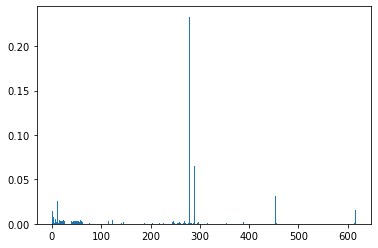

In [91]:
#Feature Importance

feature_dt = []

# get importance

importance = model_dt.feature_importances_

# summarize feature importance

for i,v in enumerate(importance):
	feature_dt.append(v)
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [92]:
# Sorting the features by importance

# Turning negative into positive scores
for i in range(len(feature_dt)):
    if feature_dt[i]<0:
        feature_dt[i] = feature_dt[i]*(-1)

feature_dt = pd.DataFrame(feature_dt)
feature_dt.reset_index(inplace=True)
feature_dt.columns = ['feature', 'score']
feature_dt['feature_name'] = X.columns
feature_dt.sort_values(by=['score'], ascending = False, inplace=True)
feature_dt.reset_index(drop = True, inplace = True)
feature_dt

,deposit_type_Non Refund,lead_time,agent_9.0,adr,total_of_special_requests,country_PRT,agent_240.0,stays_in_week_nights,required_car_parking_spaces,previous_cancellations,customer_type_Transient,stays_in_weekend_nights,booking_changes,assigned_room_type_A,adults
0,0,342,0,0.00,0,1,0,0,0,0,1,0,3,0,2
1,0,737,0,0.00,0,1,0,0,0,0,1,0,4,0,2
2,0,7,0,75.00,0,0,0,1,0,0,1,0,0,0,1
3,0,13,0,75.00,0,0,0,1,0,0,1,0,0,1,1
4,0,14,0,98.00,1,0,1,2,0,0,1,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,0,96.14,0,0,0,5,0,0,1,2,0,1,2
119386,0,102,1,225.43,2,0,0,5,0,0,1,2,0,0,3
119387,0,34,1,157.71,4,0,0,5,0,0,1,2,0,0,2
119388,0,109,0,104.40,0,0,0,5,0,0,1,2,0,1,2


Maximum:  0.9698492462311558
Mean:  0.833816369318629


<AxesSubplot:>

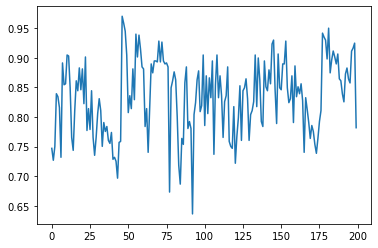

In [93]:
# K-Fold Decision Tree

model_kf_dt = cross_val_score(tree.DecisionTreeClassifier(max_depth =8), X, y, cv=200)   # Best result with max_depth =8), X, y, cv=200
print('Maximum: ', model_kf_dt.max())
print('Mean: ', model_kf_dt.mean())
model_kf_dt = pd.Series(model_kf_dt)
model_kf_dt.plot()

In [110]:
# KNN
model_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2).fit(X_train, y_train)
model_knn_prediction = model_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, model_knn_prediction)
accuracy_knn

0.7982661864477762

In [111]:
kappa_knn = cohen_kappa_score(y_test, model_knn_prediction)
kappa_knn

0.565973779592631

In [38]:
# Random Forest
model_rf = RandomForestClassifier(n_estimators=800).fit(X_train, y_train)
model_rf_prediction = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, model_rf_prediction)
accuracy_rf

0.8907362425663791

In [39]:
kappa_rf = cohen_kappa_score(y_test, model_rf_prediction)
kappa_rf

0.7606197105715611

Feature: 0, Score: 0.11337
Feature: 1, Score: 0.02456
Feature: 2, Score: 0.06015
Feature: 3, Score: 0.02645
Feature: 4, Score: 0.04015
Feature: 5, Score: 0.01425
Feature: 6, Score: 0.00659
Feature: 7, Score: 0.00090
Feature: 8, Score: 0.00274
Feature: 9, Score: 0.02738
Feature: 10, Score: 0.00414
Feature: 11, Score: 0.01981
Feature: 12, Score: 0.00286
Feature: 13, Score: 0.07771
Feature: 14, Score: 0.01963
Feature: 15, Score: 0.05583
Feature: 16, Score: 0.00705
Feature: 17, Score: 0.00690
Feature: 18, Score: 0.00577
Feature: 19, Score: 0.00713
Feature: 20, Score: 0.00416
Feature: 21, Score: 0.00471
Feature: 22, Score: 0.00364
Feature: 23, Score: 0.00690
Feature: 24, Score: 0.00580
Feature: 25, Score: 0.00526
Feature: 26, Score: 0.00606
Feature: 27, Score: 0.00385
Feature: 28, Score: 0.00539
Feature: 29, Score: 0.00468
Feature: 30, Score: 0.00678
Feature: 31, Score: 0.00089
Feature: 32, Score: 0.00490
Feature: 33, Score: 0.00390
Feature: 34, Score: 0.00097
Feature: 35, Score: 0.00033
Fe

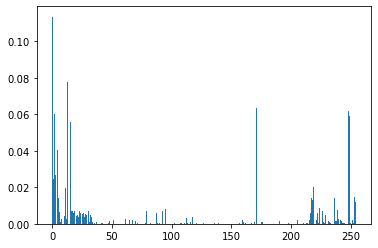

In [52]:
#Feature Importance

feature_rf = []

# get importance

importance = model_rf.feature_importances_

# summarize feature importance

for i,v in enumerate(importance):
	feature_rf.append(v)
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [53]:
# Sorting the features by importance

# Turning negative into positive scores
for i in range(len(feature_rf)):
    if feature_rf[i]<0:
        feature_rf[i] = feature_rf[i]*(-1)

feature_rf = pd.DataFrame(feature_rf)
feature_rf.reset_index(inplace=True)
feature_rf.columns = ['feature', 'score']
feature_rf['feature_name'] = X.columns
feature_rf.sort_values(by=['score'], ascending = False, inplace=True)
feature_rf.reset_index(drop = True, inplace = True)
feature_rf

,lead_time,adr,country_PRT,deposit_type_No Deposit,arrival_date_day_of_month,deposit_type_Non Refund,total_of_special_requests,stays_in_week_nights,previous_cancellations,stays_in_weekend_nights,arrival_date_year,market_segment_Online TA,booking_changes,required_car_parking_spaces,customer_type_Transient
0,342,0.00,1,1,1,0,0,0,0,0,2015,0,3,0,1
1,737,0.00,1,1,1,0,0,0,0,0,2015,0,4,0,1
2,7,75.00,0,1,1,0,0,1,0,0,2015,0,0,0,1
3,13,75.00,0,1,1,0,0,1,0,0,2015,0,0,0,1
4,14,98.00,0,1,1,0,1,2,0,0,2015,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,23,96.14,0,1,30,0,0,5,0,2,2017,0,0,0,1
119386,102,225.43,0,1,31,0,2,5,0,2,2017,1,0,0,1
119387,34,157.71,0,1,31,0,4,5,0,2,2017,1,0,0,1
119388,109,104.40,0,1,31,0,0,5,0,2,2017,1,0,0,1


In [113]:
# Ada Boost
model_ada = AdaBoostClassifier(n_estimators = 1000).fit(X_train, y_train)
model_ada_prediction = model_ada.predict(X_test)
accuracy_ada = accuracy_score(y_test, model_ada_prediction)

conf_ada = confusion_matrix(y_test, model_ada_prediction)
clf_report_ada = classification_report(y_test, model_ada_prediction)

print(f"Accuracy Score of Ada Boost Classifier is : {accuracy_ada}")
print(f"Confusion Matrix : \n{conf_ada}")
print(f"Classification Report : \n{clf_report_ada}")

Accuracy Score of Ada Boost Classifier is : 0.8419884412429852
Confusion Matrix : 
[[13666  1343]
 [ 2430  6439]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     15009
           1       0.83      0.73      0.77      8869

    accuracy                           0.84     23878
   macro avg       0.84      0.82      0.83     23878
weighted avg       0.84      0.84      0.84     23878



In [114]:
kappa_ada = cohen_kappa_score(y_test, model_ada_prediction)
kappa_ada

0.6529000264305745

In [115]:
# Gradient Boosting Classifier
model_gb = GradientBoostingClassifier().fit(X_train, y_train)
model_gb_prediction = model_gb.predict(X_test)

accuracy_gb = accuracy_score(y_test, model_gb_prediction)
conf_gb = confusion_matrix(y_test, model_gb_prediction)
clf_report_gb = classification_report(y_test, model_gb_prediction)

print(f"Accuracy Score of Ada Boost Classifier is : {accuracy_gb}")
print(f"Confusion Matrix : \n{conf_gb}")
print(f"Classification Report : \n{clf_report_gb}")

Accuracy Score of Ada Boost Classifier is : 0.8533378004858029
Confusion Matrix : 
[[13739  1270]
 [ 2232  6637]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     15009
           1       0.84      0.75      0.79      8869

    accuracy                           0.85     23878
   macro avg       0.85      0.83      0.84     23878
weighted avg       0.85      0.85      0.85     23878



In [116]:
kappa_gb = cohen_kappa_score(y_test, model_gb_prediction)
kappa_gb

0.6787807139348698

In [117]:
# XgBoost Classifier
model_xgb = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 5, n_estimators = 180).fit(X_train, y_train)
model_xgb_prediction = model_xgb.predict(X_test)

accuracy_xgb = accuracy_score(y_test, model_xgb_prediction)
conf_xgb = confusion_matrix(y_test, model_xgb_prediction)
clf_report_xgb = classification_report(y_test, model_xgb_prediction)

print(f"Accuracy Score of XgBoost Classifier is : {accuracy_xgb}")
print(f"Confusion Matrix : \n{conf_xgb}")
print(f"Classification Report : \n{clf_report_xgb}")

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[18:46:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score of XgBoost Classifier is : 0.8718904430856855
Confusion Matrix : 
[[13832  1177]
 [ 1882  6987]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.88      0.92      0.90 

In [118]:
kappa_xgb = cohen_kappa_score(y_test, model_xgb_prediction)
kappa_xgb

0.7211052337490256

In [119]:
# Cat Boost Classifier
model_cat = CatBoostClassifier(iterations=100).fit(X_train, y_train)
model_cat_prediction = model_cat.predict(X_test)

accuracy_cat = accuracy_score(y_test, model_cat_prediction)
conf_cat = confusion_matrix(y_test, model_cat_prediction)
clf_report_cat = classification_report(y_test, model_cat_prediction)

print(f"Accuracy Score of Cat Boost Classifier is : {accuracy_cat}")
print(f"Confusion Matrix : \n{conf_cat}")
print(f"Classification Report : \n{clf_report_cat}")

Learning rate set to 0.5
0:	learn: 0.4425920	total: 205ms	remaining: 20.3s
1:	learn: 0.3793647	total: 255ms	remaining: 12.5s
2:	learn: 0.3588759	total: 303ms	remaining: 9.8s
3:	learn: 0.3508771	total: 351ms	remaining: 8.42s
4:	learn: 0.3387342	total: 400ms	remaining: 7.61s
5:	learn: 0.3320042	total: 450ms	remaining: 7.06s
6:	learn: 0.3289524	total: 498ms	remaining: 6.61s
7:	learn: 0.3249602	total: 541ms	remaining: 6.22s
8:	learn: 0.3227228	total: 580ms	remaining: 5.87s
9:	learn: 0.3205647	total: 619ms	remaining: 5.57s
10:	learn: 0.3175826	total: 666ms	remaining: 5.39s
11:	learn: 0.3156407	total: 709ms	remaining: 5.2s
12:	learn: 0.3139447	total: 752ms	remaining: 5.03s
13:	learn: 0.3124122	total: 787ms	remaining: 4.83s
14:	learn: 0.3110556	total: 822ms	remaining: 4.66s
15:	learn: 0.3088176	total: 866ms	remaining: 4.55s
16:	learn: 0.3072214	total: 908ms	remaining: 4.43s
17:	learn: 0.3063461	total: 953ms	remaining: 4.34s
18:	learn: 0.3042390	total: 993ms	remaining: 4.23s
19:	learn: 0.30276

In [120]:
kappa_cat = cohen_kappa_score(y_test, model_cat_prediction)
kappa_cat

0.7314814498817086

In [121]:
# Extra Trees Classifier
model_etc = ExtraTreesClassifier().fit(X_train, y_train)
model_etc_prediction = model_etc.predict(X_test)

accuracy_etc = accuracy_score(y_test, model_etc_prediction)
conf_etc = confusion_matrix(y_test, model_etc_prediction)
clf_report_etc = classification_report(y_test, model_etc_prediction)

print(f"Accuracy Score of Cat Boost Classifier is : {accuracy_etc}")
print(f"Confusion Matrix : \n{conf_etc}")
print(f"Classification Report : \n{clf_report_etc}")

Accuracy Score of Cat Boost Classifier is : 0.8863807689086188
Confusion Matrix : 
[[14034   975]
 [ 1738  7131]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     15009
           1       0.88      0.80      0.84      8869

    accuracy                           0.89     23878
   macro avg       0.88      0.87      0.88     23878
weighted avg       0.89      0.89      0.89     23878



In [122]:
kappa_etc = cohen_kappa_score(y_test, model_etc_prediction)
kappa_etc

0.75231391122704

In [123]:
# LGBM Classifier
model_lgbm = LGBMClassifier(learning_rate = 1).fit(X_train, y_train)
model_lgbm_prediction = model_lgbm.predict(X_test)

accuracy_lgbm = accuracy_score(y_test, model_lgbm_prediction)
conf_lgbm = confusion_matrix(y_test, model_lgbm_prediction)
clf_report_lgbm = classification_report(y_test, model_lgbm_prediction)

print(f"Accuracy Score of Cat Boost Classifier is : {accuracy_lgbm}")
print(f"Confusion Matrix : \n{conf_lgbm}")
print(f"Classification Report : \n{clf_report_lgbm}")

Accuracy Score of Cat Boost Classifier is : 0.8691682720495854
Confusion Matrix : 
[[13610  1399]
 [ 1725  7144]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     15009
           1       0.84      0.81      0.82      8869

    accuracy                           0.87     23878
   macro avg       0.86      0.86      0.86     23878
weighted avg       0.87      0.87      0.87     23878



In [135]:
kappa_lgbm = cohen_kappa_score(y_test, model_lgbm_prediction)
kappa_lgbm

0.004758404612673517

In [134]:
# Voting Classifier
classifiers = [('Gradient Boosting Classifier', model_gb), ('Cat Boost Classifier', model_cat), ('XGboost', model_xgb),  
               ('Decision Tree', model_dt), ('Extra Tree', model_etc), ('Light Gradient', model_lgbm), ('Random Forest', model_rf), 
               ('Ada Boost', model_ada), ('Logistic', model_lr), ('Knn', model_knn)]
model_vc = VotingClassifier(estimators = classifiers).fit(X_train, y_train)
model_vc_prediction = model_vc.predict(X_test)

accuracy_vc = accuracy_score(y_test, model_vc_prediction)
conf_vc = confusion_matrix(y_test, model_vc_prediction)
clf_report_vc = classification_report(y_test, model_vc_prediction)

print(f"Accuracy Score of Voting Classifier is : {accuracy_vc}")
print(f"Confusion Matrix : \n{conf_vc}")
print(f"Classification Report : \n{clf_report_vc}")

NameError: name 'model_rf' is not defined

In [ ]:
kappa_vc = cohen_kappa_score(y_test, model_vc_prediction)
kappa_vc

In [ ]:
# Models Comparison
models = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Decision Tree Classifier', 'Random Forest Classifier','Ada Boost Classifier',
             'Gradient Boosting Classifier', 'XgBoost', 'Cat Boost', 'Extra Trees Classifier', 'LGBM', 'Voting Classifier'],
    'Score' : [accuracy_lr, accuracy_knn, accuracy_dt, version_rf, accuracy_ada, accuracy_gb, accuracy_xgb, accuracy_cat, # KORRIGIEREN
              accuracy_etc, accuracy_lgbm, accuracy_vc],
    'Kappa' : [kappa_lr, kappa_knn, kappa_dt, kappa_rf, kappa_ada, kappa_gb, kappa_xgb, kappa_cat, kappa_etc, kappa_lgbm, 
              kappa_vc]
})


models.sort_values(by = 'Kappa', ascending = False)

In [ ]:
# Logistic Regression with top 15 features
X_train, X_test, y_train, y_test = train_test_split(df_lr_top15, y, test_size = 0.2, random_state = 3)

model_lr_top15 = LogisticRegression().fit(X_train, y_train)
model_lr_top15_prediction = model_lr_top15.predict(X_test)
version_lr_top15 = accuracy_score(y_test, model_lr_top15_prediction)
version_lr_top15

In [ ]:
kappa_lr_top15 = cohen_kappa_score(y_test, model_lr_top15_prediction)
kappa_lr_top15

In [ ]:
# Decision Tree with top 15 features
X_train, X_test, y_train, y_test = train_test_split(df_dt_top15, y, test_size = 0.2, random_state = 3)

model_dt_top15 = tree.DecisionTreeClassifier().fit(X_train, y_train)
model_dt_top15_prediction = model_dt_top15.predict(X_test)
version_dt_top15 = accuracy_score(y_test, model_dt_top15_prediction)
version_dt_top15

In [ ]:
kappa_dt_top15 = cohen_kappa_score(y_test, model_dt_top15_prediction)
kappa_dt_top15

In [ ]:
# Random Forest with top 15 features
X_train, X_test, y_train, y_test = train_test_split(df_rf_top15, y, test_size = 0.2, random_state = 3)

model_rf_top15 = RandomForestClassifier(n_estimators=1000).fit(X_train, y_train)
model_rf_top15_prediction = model_rf_top15.predict(X_test)
version_rf_top15 = accuracy_score(y_test, model_rf_top15_prediction)
version_rf_top15

In [ ]:
kappa_rf_top15 = cohen_kappa_score(y_test, model_rf_top15_prediction)
kappa_rf_top15